In [2]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_dir = "data/"
dataObject = xrdData("data/", device)

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataObject.torch_datasets['val'], batch_size=32, shuffle=False)  

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_sgs.pt'

In [27]:
# Create the model instance and move it to the selected device
output_dim = 230  # Output dimension
ConvModel = XRD_C_SymNet(in_channels=1, output_dim=output_dim, composition_model= None).to(device)
token_size = 10 #dimension of the tokens 
TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
model = TransModel

# Define optimizer and loss function
weight_decay = 0  # Example value, adjust based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

12160


In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
count_parameters(ConvModel)

31369900

In [30]:
count_parameters(TransModel)

31500410

In [31]:
count_parameters(ConvModel) / count_parameters(TransModel)

0.995856879323158

In [32]:
#instantiate experimental data simulator 
simulator = ExperimentalSimulation(device, crop_start=2000, crop_stop = 2000, noise_range = 0.4, drop_width = 500, drop_freq = 2) 

In [33]:
for xrd, composition, targets in train_loader:
    break

In [34]:
post_sim = simulator.sim(xrd)
post_norm = F.normalize(xrd, p=2, dim=1)

In [35]:
for_viz = xrd[1].detach().cpu().numpy()
post_sim_for_viz =  post_sim[1].detach().cpu().numpy()
post_norm_for_viz = post_norm[1].detach().cpu().numpy()

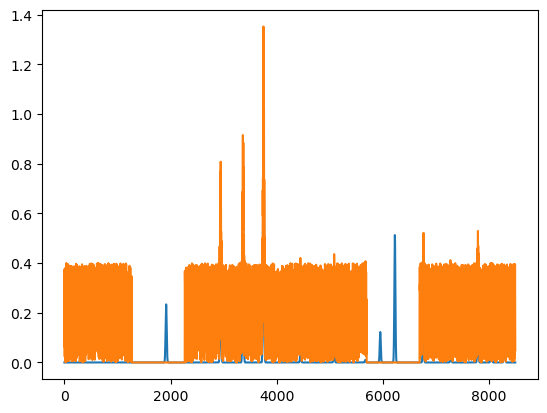

In [36]:
plt.plot(for_viz[0])
plt.plot(post_sim_for_viz[0])
# plt.plot(post_norm_for_viz[0])

In [40]:
USE_COMPOSITION = False

In [41]:
max_epochs = 200
metrics = ["accuracy", "loss"]

log = {
    f"{type}": {f"{metric}" : np.zeros(max_epochs) for metric in metrics} for type in ['train', 'val']     
}

for epoch in range(max_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xrd, composition, targets in tqdm(train_loader):
        xrd = simulator.sim(xrd)
        #xrd = F.normalize(xrd, p=2, dim=1)
        optimizer.zero_grad()
        if not USE_COMPOSITION: 
            composition = None
        outputs = model(xrd, composition)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # No gradients needed for validation
        for xrd, composition, targets in tqdm(valid_loader):
            xrd = simulator.sim(xrd)
            #xrd = F.normalize(xrd, p=2, dim=1)
            if not USE_COMPOSITION: 
                composition = None
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) 
            total_valid += targets.size(0)
            correct_valid += (predicted == targets).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid

    total_train_loss = total_train_loss / len(train_loader)
    validation_loss = total_valid_loss / len(valid_loader)

    print(f"Epoch {epoch+1}, Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}%, Validation Loss: {validation_loss}, Validation Accuracy: {valid_accuracy}%")

    log['train']['accuracy'][epoch] = (train_accuracy)
    log['train']['loss'][epoch] =(total_train_loss)

    log['val']['accuracy'][epoch] =(valid_accuracy)
    log['val']['loss'][epoch] =(validation_loss)

100%|██████████| 121/121 [00:01<00:00, 88.35it/s]


Epoch 1, Training Loss: 3.626892172804447, Training Accuracy: 18.212418300653596%, Validation Loss: 3.583831146728894, Validation Accuracy: 19.31641636457794%


100%|██████████| 121/121 [00:02<00:00, 55.66it/s]


Epoch 2, Training Loss: 3.2834942761882595, Training Accuracy: 23.5718954248366%, Validation Loss: 3.0748284454188073, Validation Accuracy: 26.281719316416364%


100%|██████████| 121/121 [00:01<00:00, 64.94it/s]


Epoch 3, Training Loss: 3.0605697786297297, Training Accuracy: 27.781045751633986%, Validation Loss: 2.9851179654933206, Validation Accuracy: 30.113930605903676%


100%|██████████| 121/121 [00:01<00:00, 63.16it/s]


Epoch 4, Training Loss: 2.9152300011526204, Training Accuracy: 30.718954248366014%, Validation Loss: 2.799546308753904, Validation Accuracy: 33.27291558777835%


100%|██████████| 121/121 [00:01<00:00, 65.48it/s]


Epoch 5, Training Loss: 2.800287456846287, Training Accuracy: 32.73529411764706%, Validation Loss: 2.6758987568626718, Validation Accuracy: 37.208700155359914%


100%|██████████| 121/121 [00:01<00:00, 65.42it/s]


Epoch 6, Training Loss: 2.709115083190216, Training Accuracy: 34.388888888888886%, Validation Loss: 2.639986159387699, Validation Accuracy: 37.62299326773692%


100%|██████████| 121/121 [00:01<00:00, 66.17it/s]


Epoch 7, Training Loss: 2.6133639727764866, Training Accuracy: 36.50326797385621%, Validation Loss: 2.5251359939575195, Validation Accuracy: 39.84981874676333%


100%|██████████| 121/121 [00:01<00:00, 61.02it/s]


Epoch 8, Training Loss: 2.562532248417287, Training Accuracy: 37.428104575163395%, Validation Loss: 2.49352693163659, Validation Accuracy: 40.91144484722941%


100%|██████████| 121/121 [00:01<00:00, 72.19it/s]


Epoch 9, Training Loss: 2.491655394325934, Training Accuracy: 38.60130718954248%, Validation Loss: 2.6169245981973064, Validation Accuracy: 37.9854997410668%


100%|██████████| 121/121 [00:01<00:00, 68.78it/s]


Epoch 10, Training Loss: 2.458176675012244, Training Accuracy: 39.372549019607845%, Validation Loss: 2.4629664598417675, Validation Accuracy: 41.29984464008286%


100%|██████████| 121/121 [00:01<00:00, 65.07it/s]


Epoch 11, Training Loss: 2.3933597297379463, Training Accuracy: 40.51960784313726%, Validation Loss: 2.4246730567995183, Validation Accuracy: 41.455204557224235%


100%|██████████| 121/121 [00:01<00:00, 66.09it/s]


Epoch 12, Training Loss: 2.3424608954067887, Training Accuracy: 41.23856209150327%, Validation Loss: 2.541915477799975, Validation Accuracy: 40.26411185914034%


100%|██████████| 121/121 [00:02<00:00, 55.66it/s]


Epoch 13, Training Loss: 2.3009537502017765, Training Accuracy: 42.19281045751634%, Validation Loss: 2.332979001289557, Validation Accuracy: 44.976696012428796%


100%|██████████| 121/121 [00:01<00:00, 72.05it/s]


Epoch 14, Training Loss: 2.2673559158947025, Training Accuracy: 43.052287581699346%, Validation Loss: 2.3349862315438012, Validation Accuracy: 44.14810978767478%


100%|██████████| 121/121 [00:01<00:00, 64.92it/s]


Epoch 15, Training Loss: 2.2210647248922846, Training Accuracy: 43.72875816993464%, Validation Loss: 2.3356091818533655, Validation Accuracy: 44.61418953909891%


100%|██████████| 121/121 [00:01<00:00, 66.41it/s]


Epoch 16, Training Loss: 2.1952767126737096, Training Accuracy: 43.86274509803921%, Validation Loss: 2.2959723580967295, Validation Accuracy: 44.976696012428796%


100%|██████████| 121/121 [00:01<00:00, 69.43it/s]


Epoch 17, Training Loss: 2.1453919548973395, Training Accuracy: 44.81372549019608%, Validation Loss: 2.2793787914859363, Validation Accuracy: 45.287415846711546%


100%|██████████| 121/121 [00:01<00:00, 65.57it/s]


Epoch 18, Training Loss: 2.1134528931903738, Training Accuracy: 45.69934640522876%, Validation Loss: 2.30265763180315, Validation Accuracy: 44.25168306576903%


100%|██████████| 121/121 [00:01<00:00, 66.77it/s]


Epoch 19, Training Loss: 2.0905341313550463, Training Accuracy: 46.19934640522876%, Validation Loss: 2.289396737232681, Validation Accuracy: 45.598135680994304%


100%|██████████| 121/121 [00:01<00:00, 70.12it/s]


Epoch 20, Training Loss: 2.0476420558483, Training Accuracy: 47.02287581699346%, Validation Loss: 2.2926695356684283, Validation Accuracy: 45.20973588814086%


100%|██████████| 121/121 [00:01<00:00, 64.58it/s]


Epoch 21, Training Loss: 2.0319160561825664, Training Accuracy: 47.50653594771242%, Validation Loss: 2.2498655063061674, Validation Accuracy: 47.566027964785086%


 63%|██████▎   | 602/957 [00:16<00:09, 36.89it/s]


KeyboardInterrupt: 

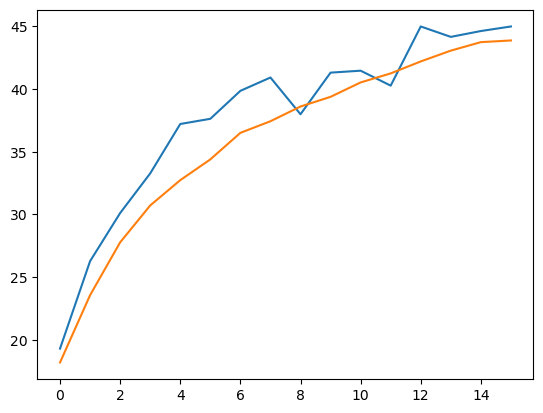

In [42]:
plt.plot(log['val']['accuracy'][:16])
plt.plot(log['train']['accuracy'][:16])

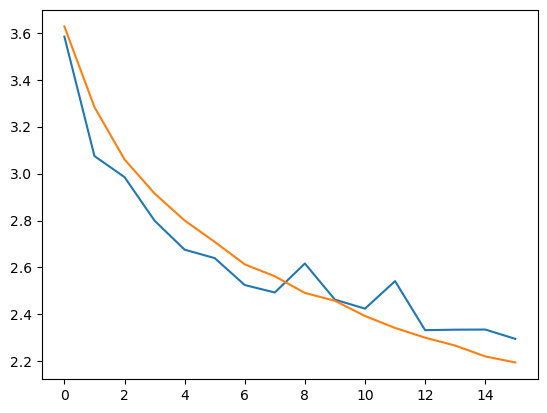

In [43]:
plt.plot(log['val']['loss'][:16])
plt.plot(log['train']['loss'][:16])

In [ ]:
model_dir = "models/"

date = datetime.now()
model_name = f"first_model_{date.month}_{date.day}"

os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)

torch.save(model, os.path.join(model_dir, model_name, 'model.pth'))

for data_type, metrics_dict in log.items():
    for metric, array in metrics_dict.items():
        filename = f"{data_type}_{metric}.npy"  # Construct filename, e.g., "train_accuracy.npy"
        filename = os.path.join(model_dir, model_name, filename)
        np.save(filename, array)  # Save the array to a file

AttributeError: module 'datetime' has no attribute 'now'